[View in Colaboratory](https://colab.research.google.com/github/pirsquared/Colaboratory/blob/master/Find_position_of_maximum_per_unique_bin_(binargmax).ipynb)

# Installs

In [1]:
!pip install numba
!pip install numpy_indexed

# Imports

In [0]:
import numpy as np
import pandas as pd
import numpy_indexed as npi
from numba import njit
from timeit import timeit
from scipy import sparse

# Problem
https://stackoverflow.com/q/52006947/2336654

## Toy Data

In [0]:
bins = np.array([0, 0, 1, 1, 2, 2, 2, 0, 1, 2])
vals = np.array([8, 7, 3, 4, 1, 2, 6, 5, 0, 9])

## Expected Output

In [4]:
def binargmax(bins, vals):
  k = bins.max() + 1
  out = -np.ones(k, np.int64)
  trk = np.empty(k, vals.dtype)
  trk.fill(np.nanmin(vals) - 1)

  for i in range(len(bins)):
    v = vals[i]
    b = bins[i]
    if v > trk[b]:
      trk[b] = v
      out[b] = i

  return out

binargmax(bins, vals)

array([0, 3, 9])

# Proposed Functions

In [0]:
def bench(bins, vals):
  k = bins.max() + 1
  out = -np.ones(k, np.int64)
  trk = np.empty(k, vals.dtype)
  trk.fill(np.nanmin(vals) - 1)

  for i in range(len(bins)):
    v = vals[i]
    b = bins[i]
    if v > trk[b]:
      trk[b] = v
      out[b] = i

  return out

def div_1(bins, vals):
  mx = vals.max()+1
  sidx = bins.argsort()
  sb = bins[sidx]
  sm = np.r_[sb[:-1] != sb[1:],True]
  argmax_out = np.argsort(bins*mx + vals)[sm]
  max_out = vals[argmax_out]
  return argmax_out
  
def div_2(bins, vals):
  last_idx = np.bincount(bins).cumsum()-1
  scaled_vals = bins*(vals.max()+1) + vals
  argmax_out = np.argsort(scaled_vals)[last_idx]
  max_out = vals[argmax_out]
  return argmax_out

def u5454(bins, vals):
  b = bins == np.arange(bins.max() + 1)[:, None]
  return np.argmax(vals * b, axis=-1)

def u2699(bins, vals):
  res = []
  for v in np.unique(bins):
    idx = bins == v
    r = np.where(idx)[0][np.argmax(vals[idx])]
    res.append(r)
  return np.array(res)

def chris_1(bins, vals):
  return npi.group_by(bins).argmax(vals)[1]

def chris_2(bins, vals):
  return sparse.csr_matrix(
      (vals, bins, np.arange(vals.shape[0]+1)),
      (vals.shape[0], bins.max() + 1)
  ).argmax(0)

def sacul_1(bins,vals):
  s = np.lexsort((vals,bins))
  s2 = np.sort(bins)
  msk = np.roll(s2,-1) != s2
  return s[msk]

def dsm_1(bins, vals):
  max_vals = np.full(bins.max()+1, -np.inf)
  np.maximum.at(max_vals, bins, vals)
  expanded = max_vals[bins]
  max_idx = np.full_like(max_vals, np.inf)
  np.minimum.at(max_idx, bins, np.where(vals == expanded, np.arange(len(bins)), np.inf))
  return max_idx

@njit
def pir_1(bins, vals):
  k = bins.max() + 1
  out = -np.ones(k, np.int64)
  trk = np.empty(k, vals.dtype)
  trk.fill(np.nanmin(vals) - 1)

  for i in range(len(bins)):
    v = vals[i]
    b = bins[i]
    if v > trk[b]:
      trk[b] = v
      out[b] = i

  return out

# Testing

## Setup

In [0]:
def gen_arrays(num_bins, len_array):
  return np.random.randint(num_bins, size=len_array), np.random.rand(len_array)

In [0]:
idx = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
fun = 'bench div_1 div_2 u5454 u2699 chris_1 chris_2 sacul_1 dsm_1 pir_1'.split()

res = pd.DataFrame(index=idx, columns=fun, dtype=np.float64)

In [16]:
pir_1(*np.zeros((2, 2), np.int64))

array([0])

## Number of Bins approximately one third length of array

In [0]:
for i in idx:
  bins, vals = gen_arrays(i // 3, i)
  for f in fun:
    stmt = f"{f}(bins, vals)"
    setp = f"from __main__ import {f}, bins, vals"
    res.at[i, f] = timeit(stmt, setp, number=30)

In [18]:
res.div(res.min(1), 0)

,bench,div_1,div_2,u5454,u2699,chris_1,chris_2,sacul_1,dsm_1,pir_1
10,31.199620,27.651588,5.859482,5.327188,14.080507,33.925533,106.570832,10.138210,9.147583,1.0
30,22.606892,18.906304,8.586430,8.030337,39.174464,46.853330,163.095049,15.826915,16.361002,1.0
100,27.829010,26.701214,6.332831,10.972710,69.281641,35.549430,163.739143,12.013765,15.010311,1.0
300,55.726380,15.825228,7.011312,52.889470,189.837700,40.597920,303.392684,18.124235,27.548747,1.0
1000,63.124051,19.328323,7.509694,945.693273,261.477946,34.237474,298.928391,24.594946,26.795757,1.0
3000,59.090719,19.104626,9.366736,1055.580896,305.680973,31.578791,264.975355,25.074740,24.228337,1.0
10000,44.812571,15.895251,8.258888,1737.859212,387.038158,25.712832,197.798263,22.374145,17.877367,1.0
30000,42.622525,16.509877,8.576783,4935.548603,750.366973,27.444819,182.940240,24.485947,17.070225,1.0


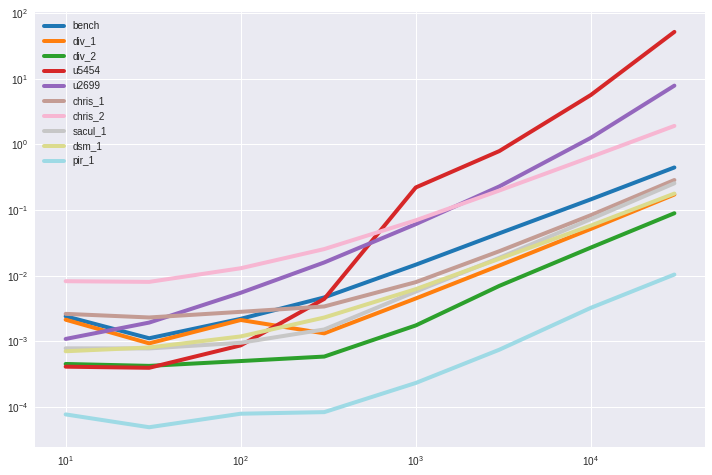

In [19]:
res.plot(loglog=True, colormap='tab20', lw=4, figsize=(12, 8))

# Validation

## Normal expected input

In [20]:
bins, vals = gen_arrays(100, 10000)
truth = bench(bins, vals)

for f in fun:
  call = np.asarray(locals()[f](bins, vals)).ravel()
  valid = (call == truth).all()
  print(f"{f:<8}: {'Valid' if valid else 'Invalid'}")

bench   : Valid
div_1   : Valid
div_2   : Valid
u5454   : Valid
u2699   : Valid
chris_1 : Valid
chris_2 : Valid
sacul_1 : Valid
dsm_1   : Valid
pir_1   : Valid


## One bin with repeated ties

In [21]:
bins = vals = np.array([0, 0, 0])
truth = bench(bins, vals)

for f in fun:
  call = np.asarray(locals()[f](bins, vals)).ravel()
  valid = (call == truth).all()
  print(f"{f:<8}: {'Valid' if valid else 'Invalid'}")

bench   : Valid
div_1   : Invalid
div_2   : Invalid
u5454   : Valid
u2699   : Valid
chris_1 : Valid
chris_2 : Valid
sacul_1 : Valid
dsm_1   : Valid
pir_1   : Valid


## Should produce more ties

In [22]:
bins, vals = gen_arrays(5, 1000)
vals = (vals * 100).astype(np.int64)
truth = bench(bins, vals)

for f in fun:
  call = np.asarray(locals()[f](bins, vals)).ravel()
  valid = (call == truth).all()
  print(f"{f:<8}: {'Valid' if valid else 'Invalid'}")

bench   : Valid
div_1   : Invalid
div_2   : Invalid
u5454   : Valid
u2699   : Valid
chris_1 : Valid
chris_2 : Valid
sacul_1 : Invalid
dsm_1   : Valid
pir_1   : Valid
